# Analysis Plan

1. Check normality in demographics
2. Transform value choices to cosine distance from expected assignments
3. Check bias in data: Any correlations between value choices and demographic data?
4. Determine power
5. Determine significance

In [1]:
import math
import statistics
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from scipy.stats import shapiro, kendalltau, linregress, iqr, skew, chisquare
from scipy.spatial.distance import cosine
from scipy.ndimage import rotate
import seaborn as sns
from statsmodels.stats import power

In [2]:
data_df = pd.read_csv('./data/study-responses.csv')
data_df.head()

,Timestamp,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,age,gender,education,reading,years_gaming,gaming_per_week,familiarity
0,6/18/2023 12:50:37,5,5,7,0,5,1,1,7,4,29,0,1,0,0,2,0
1,6/20/2023 14:12:29,5,5,7,8,4,1,1,3,4,25,1,2,1,0,2,0
2,6/20/2023 15:09:29,5,7,3,8,5,2,2,5,4,22,1,1,1,0,0,1
3,6/20/2023 22:46:46,4,5,7,8,4,2,2,3,4,28,0,3,1,0,0,0
4,6/21/2023 3:53:42,5,5,7,8,5,1,4,5,4,35,0,1,1,0,2,3


## Visualize demographics data

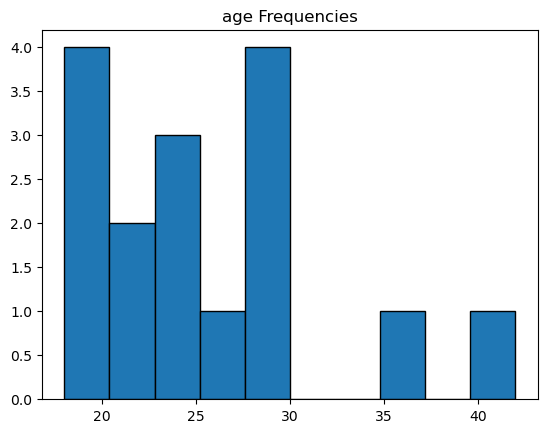

Shapiro-Wilks test: 0.10890769213438034


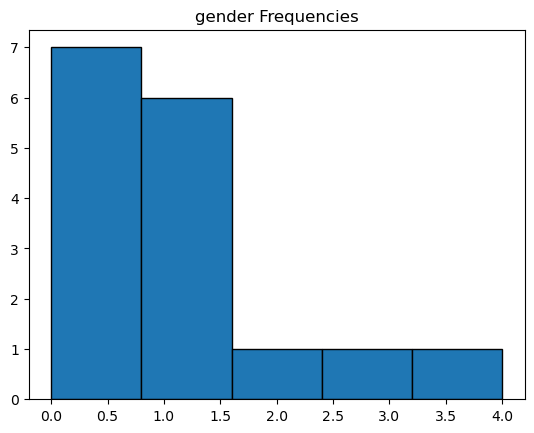

Shapiro-Wilks test: 0.0010841995244845748


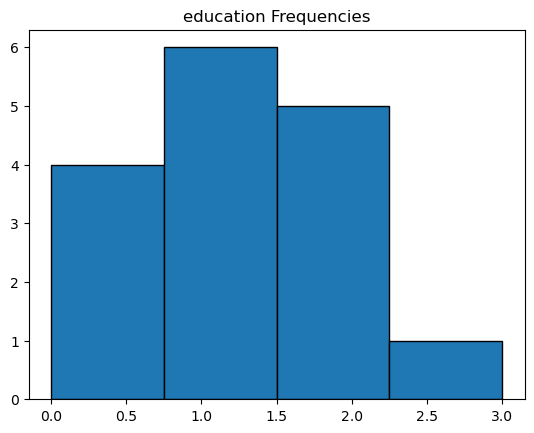

Shapiro-Wilks test: 0.0414891317486763


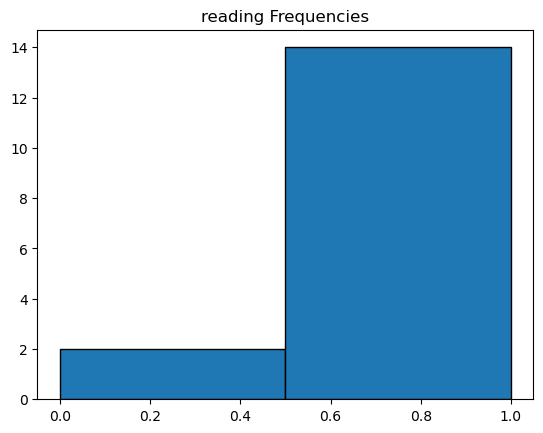

Shapiro-Wilks test: 3.4081620015058434e-07


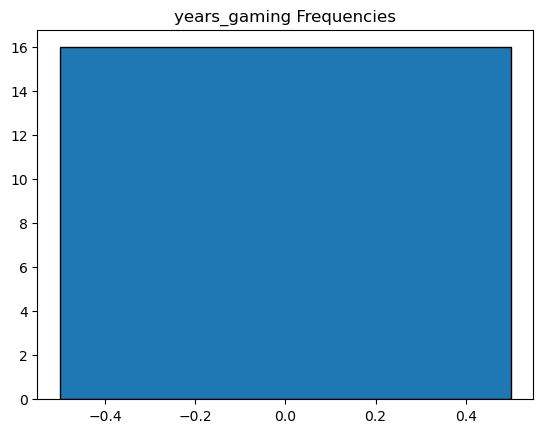

Shapiro-Wilks test: 1.0


/Users/luisgarcia/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


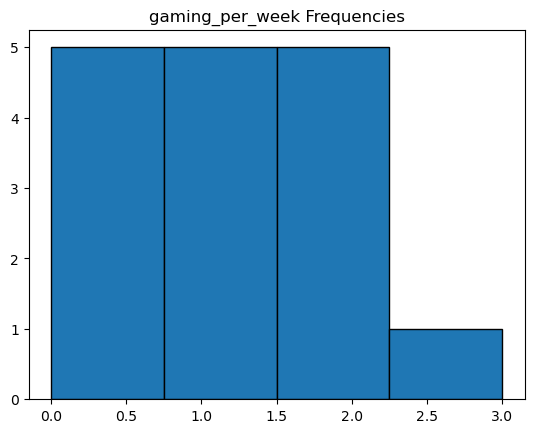

Shapiro-Wilks test: 0.026236779987812042


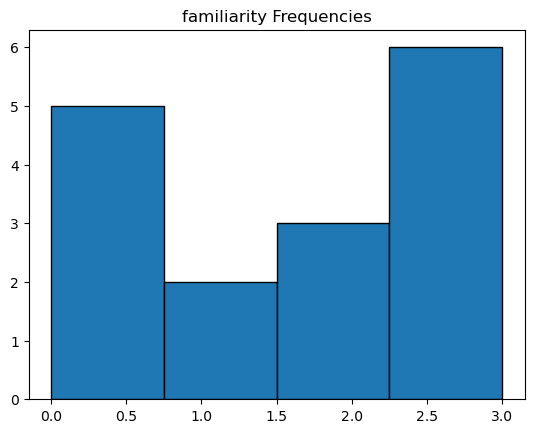

Shapiro-Wilks test: 0.0026554912328720093


In [3]:
demo_columns = ['age', 'gender', 'education', 'reading', 'years_gaming', 'gaming_per_week', 'familiarity']
ticks = [[
    18,
    22,
    24,
    25,
    28,
    29,
    35,
], [
    'male', 'female', 'nonbinary', 'don\'t know', 'none'
], [
    'high school', 'bachelor degree', 'master degree', 'doctorate'
], [
    'somewhat confident', 'extremely confident'
], [
    '5+ years'
], [
   '0-5',
    '5-10',
    '10-20',
    '20+'
], [
    'somewhat unfamiliar', 'neither familiar nor unfamiliar', 'somewhat familiar', 'very familiar'
]]

for idx, col in enumerate(demo_columns):
    # get the column from the df
    column_s = data_df[col]
    if not column_s.dtype == 'int64':
        continue
    # visualize with histogram
    figure = plt.figure()
    counts, bins = np.histogram(column_s) 
    plt.hist(column_s, bins=len(set(column_s)), label=ticks[idx], edgecolor='black')
    
    plt.title(f'{col} Frequencies')
    plt.show()
    # shapiro wilk test for normality
    res = shapiro(column_s)
    print(f'Shapiro-Wilks test: {res.pvalue}')
    

In [4]:
### Same as above, but with value assignments

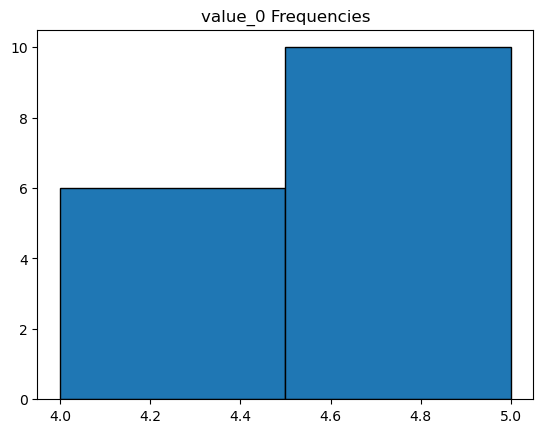

Shapiro-Wilks test: 2.5657316655269824e-05


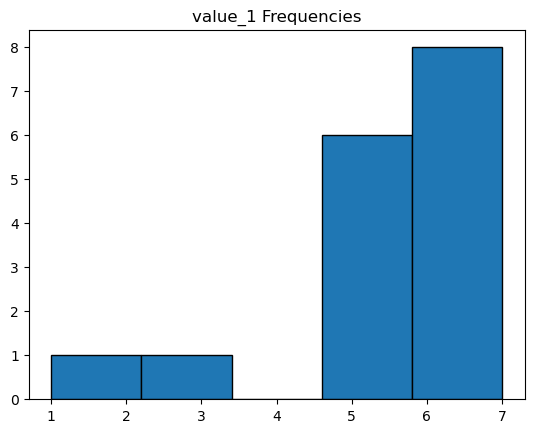

Shapiro-Wilks test: 0.005220930092036724


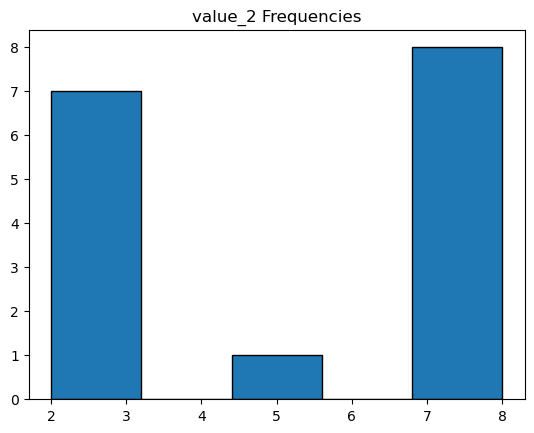

Shapiro-Wilks test: 0.0016493002185598016


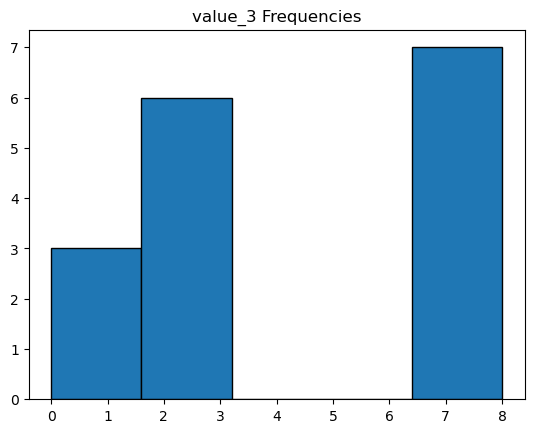

Shapiro-Wilks test: 0.0036147399805486202


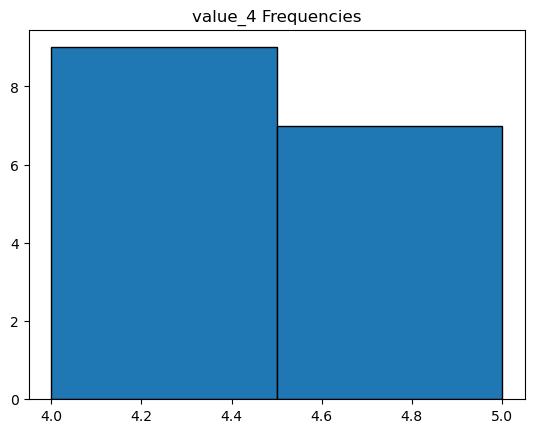

Shapiro-Wilks test: 3.8051271985750645e-05


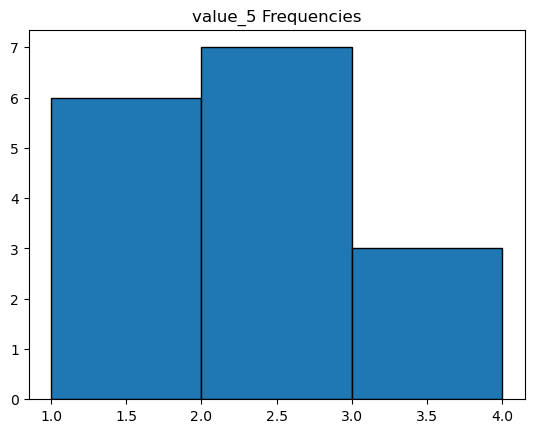

Shapiro-Wilks test: 0.0008426883141510189


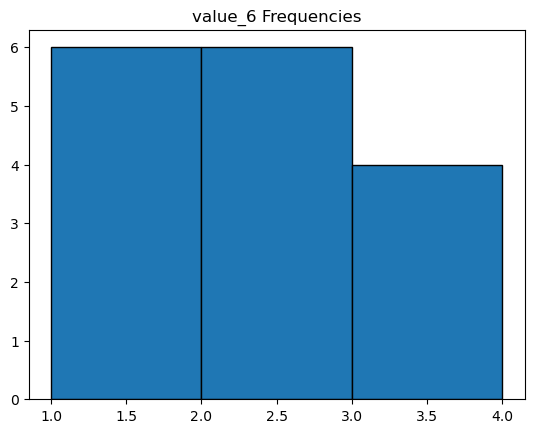

Shapiro-Wilks test: 0.0010503422236070037


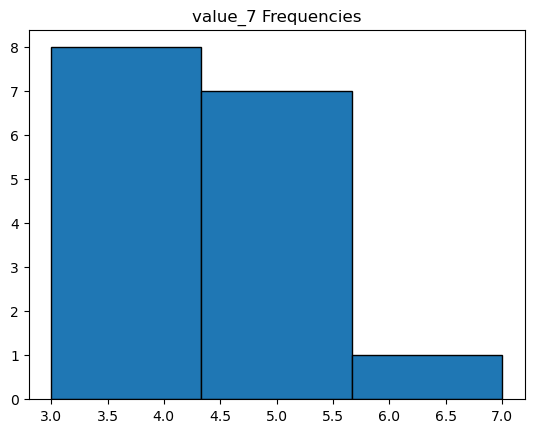

Shapiro-Wilks test: 0.0006388467736542225


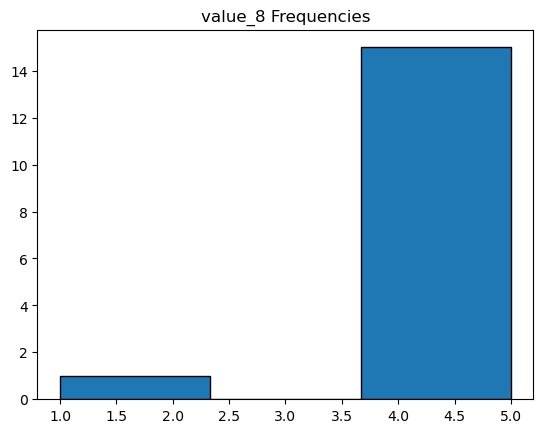

Shapiro-Wilks test: 4.892751803708961e-07


In [5]:
value_assignment_columns = [ f'value_{i}' for i in range(9) ]

for idx, col in enumerate(value_assignment_columns):
    # get the column from the df
    column_s = data_df[col]
    if not column_s.dtype == 'int64':
        continue
    # visualize with histogram
    figure = plt.figure()
    counts, bins = np.histogram(column_s) 
    plt.hist(column_s, bins=len(set(column_s)), edgecolor='black')
    
    plt.title(f'{col} Frequencies')
    plt.show()
    # shapiro wilk test for normality
    res = shapiro(column_s)
    print(f'Shapiro-Wilks test: {res.pvalue}')

## Test Correlations

In [6]:
subplot_height = len(demo_columns)
subplot_width = 9

demo_types = ['interval', 'nominal', 'ordinal', 'ordinal', 'ordinal', 'ordinal', 'ordinal']
alpha = 0.05

corr_df = []
sig_corr_df = []
for idx, demo in enumerate(demo_columns):
    results = { 'demographic': demo }
    sig_results = { 'demographic': demo }
    for jdx, assignment in enumerate(value_assignment_columns):
        if demo_types[idx] == 'nominal':
            corr = linregress(data_df[demo], data_df[assignment])
            results[assignment] = f'{corr.slope}, p={corr.pvalue}'
            
            if corr.pvalue < alpha:
                sig_results[assignment] = f'{corr.slope}, p={corr.pvalue}'
        else:
            corr = kendalltau(data_df[demo], data_df[assignment])
            results[assignment] = f'{corr.correlation}, p={corr.pvalue}'
            if corr.pvalue < alpha:
                sig_results[assignment] = f'{corr.correlation}, p={corr.pvalue}'
    
    corr_df.append(results)
    sig_corr_df.append(sig_results)
    
corr_df = pd.DataFrame(corr_df)
sig_corr_df = pd.DataFrame(sig_corr_df)
display(corr_df)

,demographic,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8
0,age,"0.13300397918683549, p=0.5490340674475802","-0.21366273380762385, p=0.2959158115570252","0.28613169175965075, p=0.1700498697131193","-0.11913347696647582, p=0.5633489007714996","0.2713970580718357, p=0.2214448100164681","-0.22894319838663632, p=0.27897945111762246","0.11240887890557708, p=0.5931109839933149","0.2334198011270493, p=0.28143026117446046","0.33044727612563335, p=0.13090989805964104"
1,gender,"0.029850746268656716, p=0.7951920627033353","0.06567164179104477, p=0.857254641776167","-0.08955223880597014, p=0.8568030792781887","0.5582089552238806, p=0.4175882891162874","0.06865671641791045, p=0.5581292726831509","0.6208955223880597, p=0.004544562296062653","0.19701492537313434, p=0.47319584631797607","0.05373134328358209, p=0.8528006846811527","0.1373134328358209, p=0.45488953160517476"
2,education,"0.19158319302639065, p=0.4246544567104097","0.13189999176999037, p=0.5495564063294288","0.011565525051480625, p=0.9590078302512948","0.03370786516853933, p=0.8795064176597396","-0.1736113340465842, p=0.4693854333119457","-0.2944438555573223, p=0.1971082585637709","0.034696575154441876, p=0.8785465645361632","-0.18869790625738755, p=0.42023873350729046","0.17715299831526518, p=0.4536333533831509"
3,reading,"0.0975900072948533, p=0.7054569861112734","0.03919309008348102, p=0.8684593641626578","-0.45363235436327737, p=0.06057001626174749","0.10016038502687549, p=0.6748923937066393","-0.047619047619047616, p=0.8536778795643177","-0.06299407883487121, p=0.7973514701113643","0.4123930494211613, p=0.09096894797535775","-0.1569964564056898, p=0.5328840277868037","0.0, p=1.0"
4,years_gaming,"nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan"
5,gaming_per_week,"0.21773242158072692, p=0.3634879469815159","-0.1311651671567906, p=0.5511897236542531","0.3335316870154712, p=0.13767994741748277","-0.11173358719233183, p=0.6147862635603549","0.38512921856330457, p=0.10796783678892491","-0.1288335343031562, p=0.5719251582599756","0.11501092655705905, p=0.6119445797815588","0.3752933125204007, p=0.10838823840140077","0.4893501829289196, p=0.03815734934924439"
6,familiarity,"-0.2165327847843067, p=0.3634879469815159","0.18479352545983008, p=0.39858273239924435","0.011437725271791939, p=0.9591800501346881","0.22223594091360938, p=0.31424716085984583","0.06603573764586061, p=0.7816749139007505","0.11647609296910205, p=0.607402925802327","0.18300360434867102, p=0.41702696496642633","0.111967669510588, p=0.6300752236443857","-0.21412776798704747, p=0.3616821476869727"


In [7]:
sig_corr_df

,demographic,value_5,value_8
0,age,NaN,NaN
1,gender,"0.6208955223880597, p=0.004544562296062653",NaN
2,education,NaN,NaN
3,reading,NaN,NaN
4,years_gaming,NaN,NaN
5,gaming_per_week,NaN,"0.4893501829289196, p=0.03815734934924439"
6,familiarity,NaN,NaN


Appears to be some correlation between gender and the assignment on prompt #4 (indexed at 5), and gaming_per_week with prompt #9.

## Preprocess Data

Transform data into signed distances from the expected value.

|value_index |value_real| value_label       |
|------------|----------|-------------------|
| 0          | -4       | self-direction    |
| 1          | -3       | universalism      |
| 2          | -2       | benevolence       |
| 3          | -1       | tradition         |
| 4          |  0       | security          |
| 5          |  1       | power             |
| 6          |  2       | achievement       |
| 7          |  3       | hedonism          |
| 8          |  4       | stimulation       |

In [8]:
expected_values_per_prompt = [
    5, # Expected value: power, Use Materials for Weapon Manufacturing
    6, # Expected value: achievement, Hold Parade of Victories
    7, # Expected value: hedonism, Hold a Festival for the God of Pleasure
    8, # Expected value: stimulation, Maintain an Art Museum
    4, # Expected value: security, Punish a Criminal
    2, # Expected value: benevolence, Maintain a Hospital
    1, # Expected value: universalism, Open Food Rations to Peasants
    3, # Expected value: tradition, Enforce an Hour of Prayer
    4, # Expected value: security, Reinforce the Capital City's Walls
]

values = [ 'self-direction', 'universalism', 'benevolence', 'tradition', 'security', 'power', 'achievement', 'hedonism', 'stimulation' ]
value_to_idx = { value:idx for idx, value in enumerate(values) }
VALUE_COUNT = 9

In [9]:
def computeSignedDistance(value1, value2):
    global VALUE_COUNT
    
    value2_trans1 = value2 - VALUE_COUNT
    value2_trans2 = value2 + VALUE_COUNT
    
    values_to_compare_against = [value2, value2_trans1, value2_trans2]
    
    min_dist = None
    sign = None
    for val in values_to_compare_against:
        if min_dist is None or abs(value1 - val) < min_dist:
            min_dist = abs(value1 - val)
            
            if value1 > val:
                sign = -1
            else:
                sign = 1
        
    return sign * min_dist    

In [10]:
def calculateSignedDeviations(expected_values):
    global data_df
    global value_assignment_columns
        
    distance_df = []
    for row in data_df.iloc:
        new_row = {}
        for idx, col in enumerate(value_assignment_columns):    
            new_row[col] = computeSignedDistance(expected_values[idx], row[col])

        distance_df.append(new_row)

    return pd.DataFrame(distance_df)

In [11]:
distance_df = calculateSignedDeviations(expected_values_per_prompt)
display(distance_df)

,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8
0,0,-1,0,1,1,-1,0,4,0
1,0,-1,0,0,0,-1,0,0,0
2,0,1,-4,0,1,0,1,2,0
3,-1,-1,0,0,0,0,1,0,0
4,0,-1,0,0,1,-1,3,2,0
5,0,0,-4,0,0,0,1,2,0
6,-1,0,1,0,0,2,0,0,0
7,0,1,-4,4,0,-1,0,2,0
8,-1,4,4,-1,1,2,3,0,-3
9,-1,-1,0,4,0,0,1,0,0


In [12]:
def plotSignedDeviationDistributions(signed_deviation_df):
    bins = list(range(-5, 6))
    fig, axs = plt.subplots(3, 3, sharex=False, sharey=True, figsize=(12, 14))
    plots = axs.reshape(9,)
    for value_index, row in enumerate(signed_deviation_df.T.iloc):
        plot = plots[value_index]
        plot.hist(row, bins=bins, align='left', edgecolor='black')

    fig.supxlabel('Signed Distance')
    fig.supylabel('Count')
    plt.show()

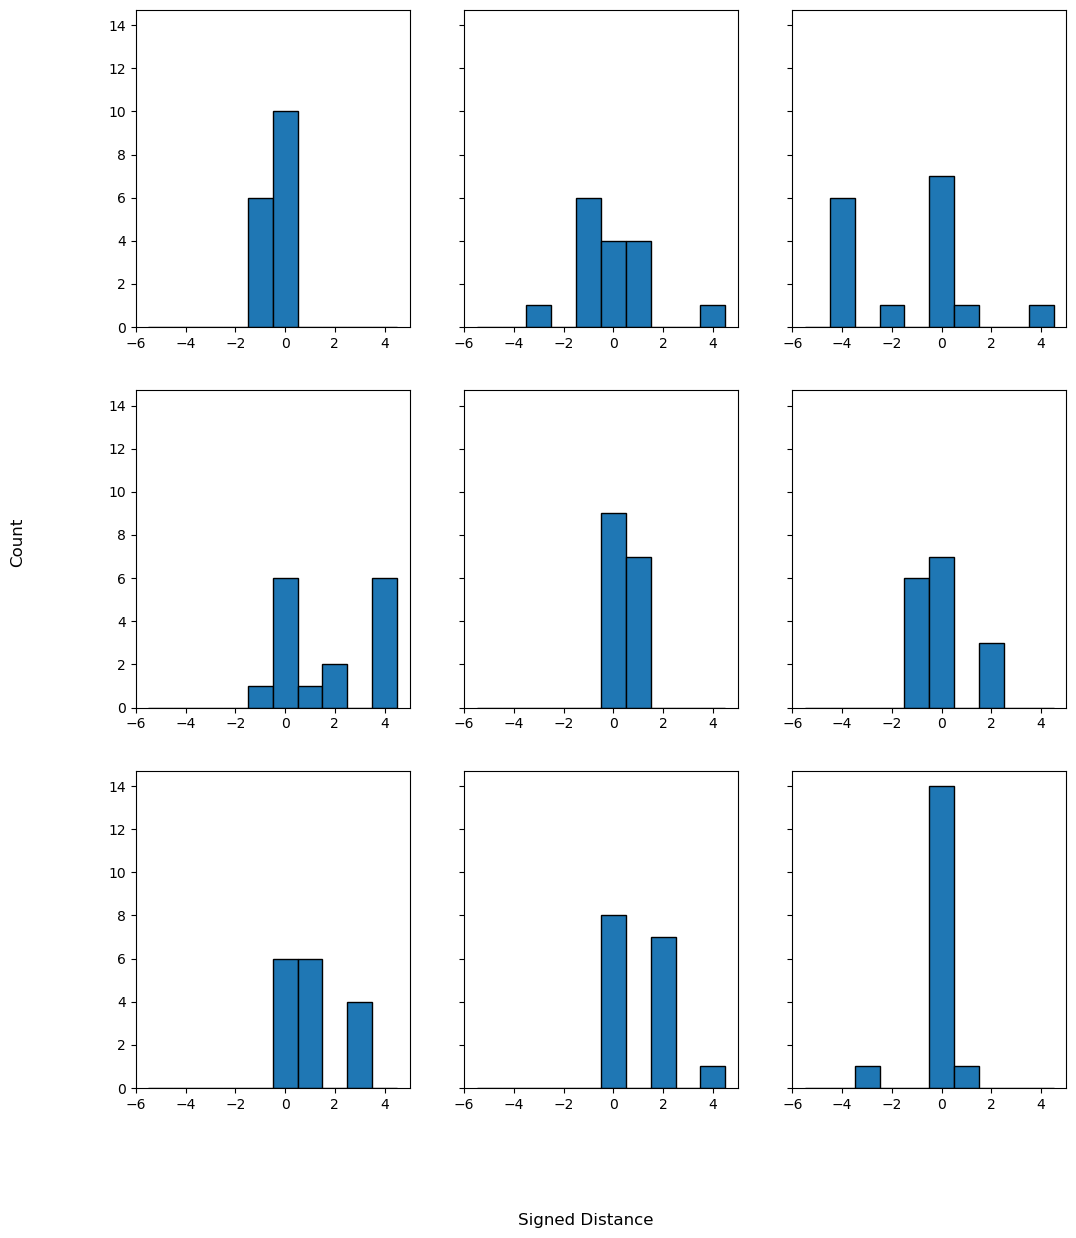

In [13]:
plotSignedDeviationDistributions(distance_df)

## Descriptive Statistics


In the following section, we calculate a few descriptive measures of our dataset. The most important one is the adjustment weight, which defined as the weighted average deviation modulated by the probability of each deviation. Formally, it is:

$AW = \sum \limits _{i=0} ^{N} d_i \times W(d_i) \times P(d_i) $

where $d_i$ is the amount that the $i^{th}$ response deviates from the expected value, ${W:\mathbb{Z}\rightarrow\mathbb{R}}$ is a function that calculates the weight of the deviation, and ${P:\mathbb{Z}\rightarrow\mathbb{R}}$ is the| deviation's probability given its sample population.

The exact weight for a given deviation $d_i$ is:

$W(d_i) = \frac{|d_i|}{20}$.

Why is $20$ the denominator? We use $20$ as the denominator so that the set of possible weights for the random variable we are concerned with (that is, $[-4,4]$) sum to 1.



In [14]:
def calcOddsOfDeviation(dev, deviation_series):
    return deviation_series.value_counts()[dev] / len(deviation_series)

def calcDeviationWeight(dev):
    return (math.sqrt(math.pow(dev, 2)) / 20)

stats_df = []
alpha = 0.05
for value_index, row in enumerate(distance_df.T.iloc):
    test_res = shapiro(row)
    
    adjustment_weight = sum( [ distance * calcDeviationWeight(distance) * calcOddsOfDeviation(distance, row) for distance in row ])    
    
    stats_df.append({
        'mean_signed_deviation': statistics.mean(row),
        'adjustment_weight': adjustment_weight,
        'median_deviation': statistics.median(row),
        'mode': statistics.mode(row),
        'iqr': iqr(row),
        'std': row.std(),
        'skewness': skew(row),
        'shapiro-statistic': test_res.statistic,
        'shapiro-pvalue': test_res.pvalue,
        'shapiro-is_sig': test_res.pvalue < alpha
    })
    
stats_df = pd.DataFrame(stats_df)
display(stats_df)

,mean_signed_deviation,adjustment_weight,median_deviation,mode,iqr,std,skewness,shapiro-statistic,shapiro-pvalue,shapiro-is_sig
0,-0.3750,-0.112500,0.0,0,1.0,0.500000,-0.516398,0.620887,2.565732e-05,True
1,-0.0625,-0.040625,0.0,-1,2.0,1.526161,0.804901,0.877965,3.607818e-02,True
2,-1.3125,-1.759375,0.0,0,4.0,2.441823,0.290065,0.821985,5.416411e-03,True
3,1.7500,1.850000,1.5,0,4.0,1.949359,0.139424,0.798773,2.623348e-03,True
4,0.4375,0.153125,0.0,0,1.0,0.512348,0.251976,0.638266,3.805127e-05,True
5,0.0000,0.000000,0.0,0,1.0,1.095445,0.942809,0.760091,8.426883e-04,True
6,1.1250,0.562500,1.0,0,1.5,1.204159,0.702419,0.767827,1.050342e-03,True
7,1.1250,0.662500,1.0,0,2.0,1.258306,0.589668,0.750202,6.388468e-04,True
8,-0.1250,-0.025000,0.0,0,0.0,0.806226,-2.931577,0.419469,4.892752e-07,True


None of the distributions of deviations are normal, meaning we cannot rely on the mean as a reliable representation of how far off our expected values are. In this case, the median is a more reliable measure, but we run the risk of losing information when the data is more centered, such as for prompt #3. For this reason, we opted to use the adjustment weight (defined above), which is less sensitive than the mean, but more sensitive than the median when calculating the error.

## Adjusting the values

Below, we simply add the adjustment weight to our expected values to yield the new values. We do the same with the median deviation for the sake of comparison. As can be seen, the adjustment weight is more sensitive to high amounts of variance than the median is, as can be seen in row 3 (indexed as 2).

In [15]:
values_df = []

for idx, expected_value in enumerate(expected_values_per_prompt):
    aw = stats_df.iloc[idx]['adjustment_weight']
    median = stats_df.iloc[idx]['median_deviation']
    new_value = round(expected_value + aw) % len(values)

    
    values_df.append({
        'expected_value': values[expected_value],
        'adjustment_weight': aw,
        'median_deviation': median,
        'new_value (adjustment_weight)': values[round(expected_value + aw) % len(values)],
        'new_value (median_deviation)': values[round(expected_value + median) % len(values) ]
    })
    
values_df = pd.DataFrame(values_df)
display(values_df)

,expected_value,adjustment_weight,median_deviation,new_value (adjustment_weight),new_value (median_deviation)
0,power,-0.112500,0.0,power,power
1,achievement,-0.040625,0.0,achievement,achievement
2,hedonism,-1.759375,0.0,power,hedonism
3,stimulation,1.850000,1.5,universalism,universalism
4,security,0.153125,0.0,security,security
5,benevolence,0.000000,0.0,benevolence,benevolence
6,universalism,0.562500,1.0,benevolence,benevolence
7,tradition,0.662500,1.0,security,security
8,security,-0.025000,0.0,security,security


In [16]:
adjusted_expected_values_per_prompt = [ value_to_idx[row['new_value (adjustment_weight)']] for row in values_df.iloc ]
display(adjusted_expected_values_per_prompt)

[5, 6, 5, 1, 4, 2, 2, 4, 4]

In [17]:
adjusted_deviation_df = calculateSignedDeviations(adjusted_expected_values_per_prompt)
display(adjusted_deviation_df)

,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8
0,0,-1,2,-1,1,-1,-1,3,0
1,0,-1,2,-2,0,-1,-1,-1,0
2,0,1,-2,-2,1,0,0,1,0
3,-1,-1,2,-2,0,0,0,-1,0
4,0,-1,2,-2,1,-1,2,1,0
5,0,0,-2,-2,0,0,0,1,0
6,-1,0,3,-2,0,2,-1,-1,0
7,0,1,-2,2,0,-1,-1,1,0
8,-1,4,-3,-3,1,2,2,-1,-3
9,-1,-1,2,2,0,0,0,-1,0


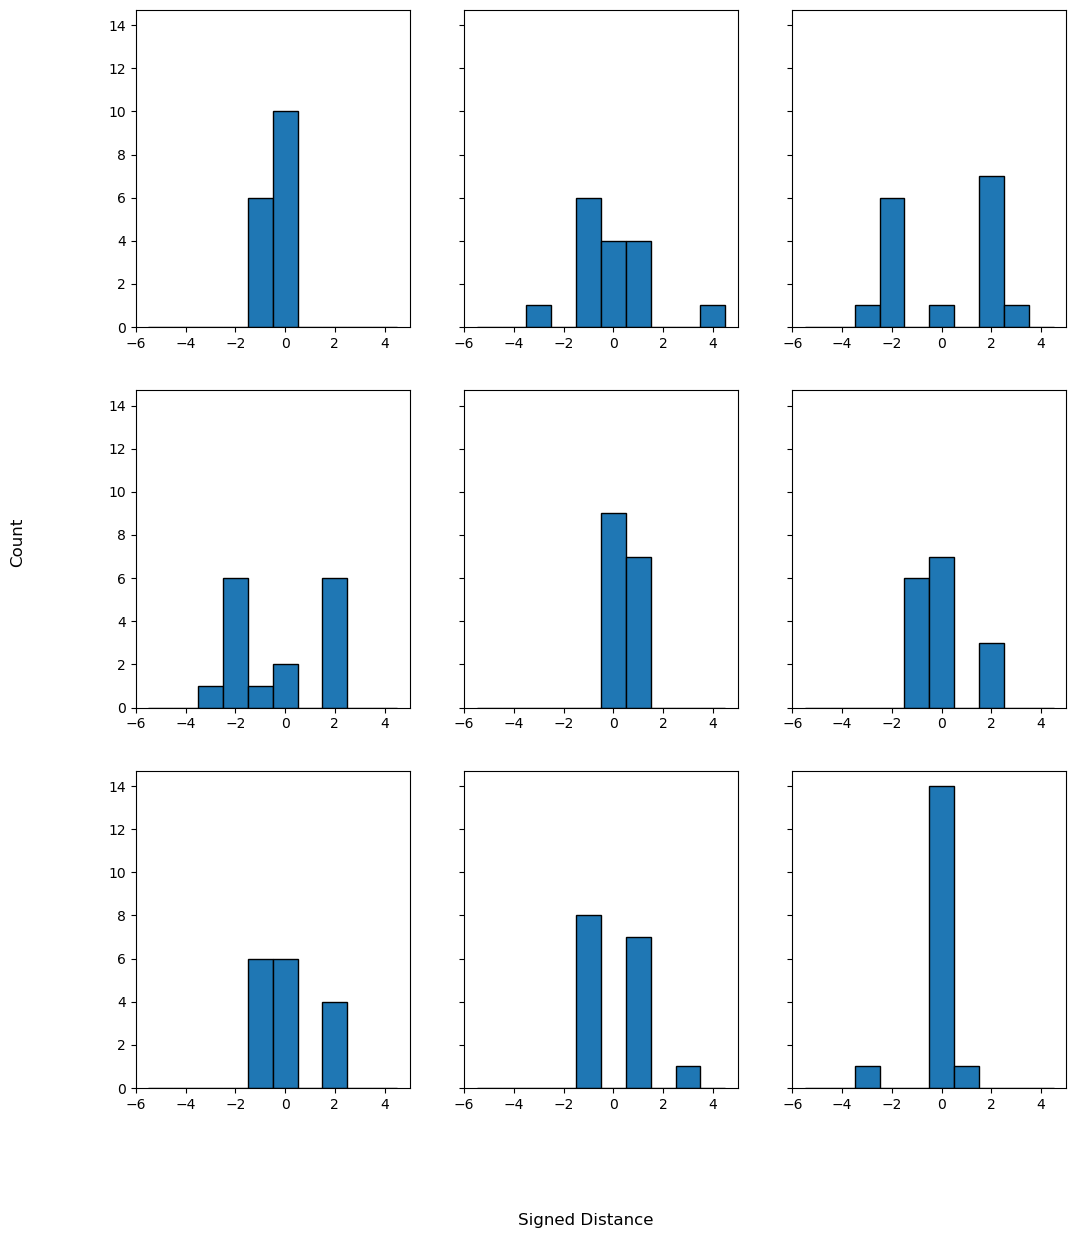

In [18]:
plotSignedDeviationDistributions(adjusted_deviation_df)

In [19]:
chisquared_df = []

def cohens_d(sample_1_df, sample_2_df):
    numerator = (sample_1_df.mean() - sample_2_df.mean())
    denominator = math.sqrt((sample_1_df.std() ** 2 + sample_2_df.std() ** 2) / 2)
    return numerator / denominator


for row_idx, obs_row in enumerate(adjusted_deviation_df.T.iloc):
    obs_freqs = { deviation: 0 for deviation in range(-4, 5) }
    exp_freqs = { deviation: 0 for deviation in range(-4, 5) }
    
    expected_row = distance_df.T.iloc[row_idx]
    print(obs_row.to_numpy())
    print(expected_row.to_numpy())
    
    for val in obs_row:
        obs_freqs[val] += 1
        
    for val in expected_row:
        exp_freqs[val] += 1
     
    obs_arr = [ freq + 1 for freq in obs_freqs.values() ]
    exp_arr = [ freq + 1 for freq in exp_freqs.values() ]
    
    print(obs_arr, sum(obs_arr))
    print(exp_arr, sum(exp_arr))
    print()
            
    res = chisquare(f_obs=obs_arr, f_exp=exp_arr)
    
    powerCalculator = power.GofChisquarePower()
    effect_size = cohens_d(obs_row, expected_row)
        
    chisquared_df.append({
        'statistic': res.statistic,
        'pvalue': res.pvalue,
        'is_significant': res.pvalue < 0.05,
        'effect_size': effect_size,
        'power': powerCalculator.power(effect_size=effect_size, nobs=sum(obs_arr), alpha=0.05, n_bins=len(obs_arr))
    })
    
    
chisquared_df = pd.DataFrame(chisquared_df)
display(chisquared_df)

[ 0  0  0 -1  0  0 -1  0 -1 -1  0  0  0 -1 -1  0]
[ 0  0  0 -1  0  0 -1  0 -1 -1  0  0  0 -1 -1  0]
[1, 1, 1, 7, 11, 1, 1, 1, 1] 25
[1, 1, 1, 7, 11, 1, 1, 1, 1] 25

[-1 -1  1 -1 -1  0  0  1  4 -1 -1  1  1 -3  0  0]
[-1 -1  1 -1 -1  0  0  1  4 -1 -1  1  1 -3  0  0]
[1, 2, 1, 7, 5, 5, 1, 1, 2] 25
[1, 2, 1, 7, 5, 5, 1, 1, 2] 25

[ 2  2 -2  2  2 -2  3 -2 -3  2  0 -2 -2  2  2 -2]
[ 0  0 -4  0  0 -4  1 -4  4  0 -2 -4 -4  0  0 -4]
[1, 2, 7, 1, 2, 1, 8, 2, 1] 25
[7, 1, 2, 1, 8, 2, 1, 1, 2] 25

[-1 -2 -2 -2 -2 -2 -2  2 -3  2  2  2  2  0  2  0]
[ 1  0  0  0  0  0  0  4 -1  4  4  4  4  2  4  2]
[1, 2, 7, 2, 3, 1, 7, 1, 1] 25
[1, 1, 1, 2, 7, 2, 3, 1, 7] 25

[1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0]
[1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0]
[1, 1, 1, 1, 10, 8, 1, 1, 1] 25
[1, 1, 1, 1, 10, 8, 1, 1, 1] 25

[-1 -1  0  0 -1  0  2 -1  2  0  2 -1  0  0  0 -1]
[-1 -1  0  0 -1  0  2 -1  2  0  2 -1  0  0  0 -1]
[1, 1, 1, 7, 8, 1, 4, 1, 1] 25
[1, 1, 1, 7, 8, 1, 4, 1, 1] 25

[-1 -1  0  0  2  0 -1 -1  2  0  2  2  0  0 -1 -1]


,statistic,pvalue,is_significant,effect_size,power
0,0.000000,1.000000e+00,False,0.000000,0.050000
1,0.000000,1.000000e+00,False,0.000000,0.050000
2,74.142857,7.322225e-13,True,0.624042,0.573774
3,50.261905,3.639426e-08,True,-1.025978,0.975893
4,0.000000,1.000000e+00,False,0.000000,0.050000
5,0.000000,1.000000e+00,False,0.000000,0.050000
6,60.342857,3.992099e-10,True,-0.830455,0.861598
7,127.736111,8.331247e-24,True,-0.794719,0.823366
8,0.000000,1.000000e+00,False,0.000000,0.050000


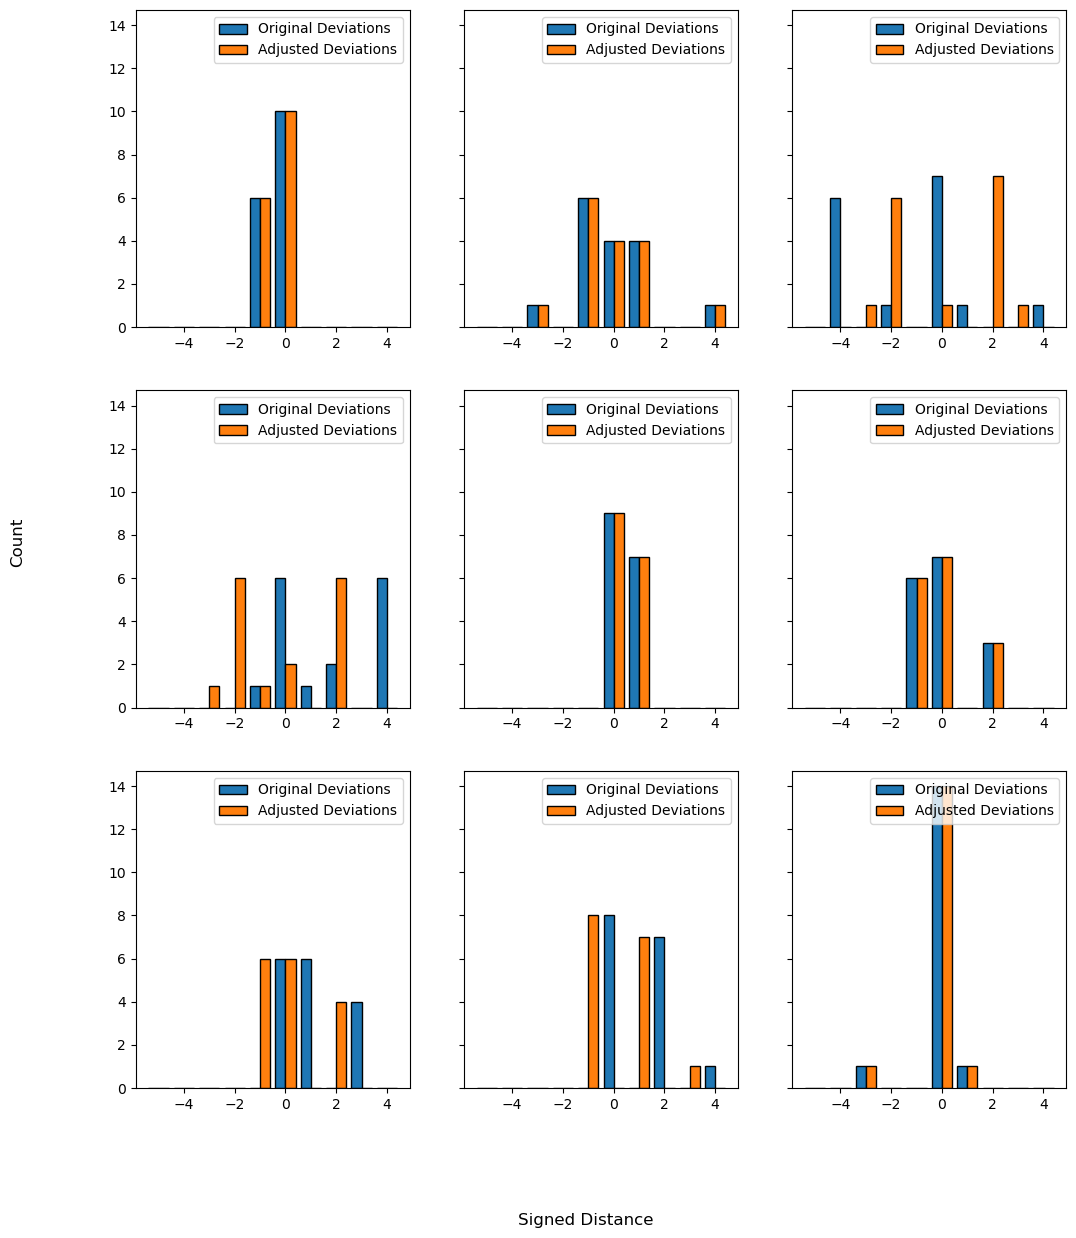

In [23]:
bins = list(range(-5, 6))
fig, axs = plt.subplots(3, 3, sharex=False, sharey=True, figsize=(12, 14))
plots = axs.reshape(9,)
for row_index, row in enumerate(distance_df.T.iloc):
    plot = plots[row_index]
    plot.hist([row, adjusted_deviation_df.T.iloc[row_index]], bins=bins, align='left', edgecolor='black', label=['Original Deviations', 'Adjusted Deviations'])
    plot.legend()
    
fig.supxlabel('Signed Distance')
fig.supylabel('Count')
plt.show()